In [1]:
nCPU = 4
import time, os, sys, pickle, h5py, importlib, gc, copy, re, itertools, timeit, json
os.environ['OMP_NUM_THREADS'] = str(nCPU)
os.environ['MKL_NUM_THREADS'] = str(nCPU)
os.environ['NUMEXPR_NUM_THREADS'] = str(nCPU)
from tqdm.auto import tqdm, trange
from collections import OrderedDict, deque, defaultdict
from pathlib import Path

import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np, pandas as pd, scipy
from scipy.stats import zscore, ttest_ind, spearmanr, pearsonr
from scipy.sparse import coo_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.metrics import silhouette_score, adjusted_rand_score

from umap import UMAP

torch.set_num_threads(nCPU)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style("white")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
context = dict(device='cuda:0', dtype=torch.float32)

In [3]:
def reload_all():
    import model, load_data, estimate_parameters, estimate_weights, util, initialization, sample_for_integral
    importlib.reload(util)
    importlib.reload(load_data)
    importlib.reload(sample_for_integral)
    importlib.reload(estimate_parameters)
    importlib.reload(estimate_weights)
    importlib.reload(initialization)
    importlib.reload(model)

reload_all()

In [4]:
# path2dataset = Path('/work/magroup/tianming/Researches/SpiceMix/version1/data/obsolete/synthetic_500_100_20_15_0_0_i4')
# path2dataset = Path('/work/magroup/tianming/Researches/SpiceMix/version1/data/obsolete/synthetic_500_100_20_15_0_0_i5')
path2dataset = Path('/media/data/tianming/Researches/RNAseq-seqFISH/version1/data/synthetic_500_100_20_15_0_0_i4')
# path2dataset = Path('/media/data/tianming/Researches/RNAseq-seqFISH/version1/data/synthetic_500_100_30_15_0_0_i0')
# path2dataset = Path('/media/data/tianming/Researches/RNAseq-seqFISH/version1/data/synthetic_500_100_30_15_0_0_i1')
# path2dataset = Path('/media/data/tianming/Researches/RNAseq-seqFISH/version1/data/synthetic_500_100_30_15_0_0_i2')
# repli_list = ['0', '1']
repli_list = ['0']

coor = np.loadtxt(path2dataset / 'files/coordinates_0.txt')

OSError: /media/data/tianming/Researches/RNAseq-seqFISH/version1/data/synthetic_500_100_20_15_0_0_i4/files/coordinates_0.txt not found.

In [ ]:
%%time
reload_all()
from model import SpiceMixPlus
from util import clustering_louvain_nclust, evaluate_embedding, evaluate_prediction_wrapper
from sklearn.cluster import AgglomerativeClustering

# evaluate = lambda obj, f=evaluate_embedding: f(obj, embedding='X', do_plot=True, do_sil=True)
def evaluate(obj):
    evaluate_embedding(obj, embedding='X', do_plot=True, do_sil=True)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(obj.Sigma_x_inv.cpu().numpy(), annot=True, fmt='.1f')
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for ax, x in zip(axes.flat, obj.Xs[0].cpu().numpy().T):
        sns.scatterplot(x=coor[:, 0], y=coor[:, 1], hue=x, ax=ax)
    plt.show()
    plt.close()

obj = SpiceMixPlus(
    K=10, lambda_Sigma_x_inv=1e-2,
    repli_list=repli_list,
    context=context,
#     context_Y=dict(dtype=torch.float32, device='cpu'),
    context_Y=context,
)
obj.load_dataset(path2dataset)
obj.meta['cell type'] = obj.meta['cell type'].astype('category')
obj.initialize(
    method='kmeans',
#     method='svd',
    random_state=2,
)
# print(obj.sigma_yxs)
# obj.sigma_yxs[:] = 1e-2
# for prior_x in obj.prior_xs: prior_x[0][:] = 0
# evaluate(obj)
for iiter in trange(20):
    obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
    obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)
evaluate(obj)
obj.initialize_Sigma_x_inv()
for iiter in range(1, 51):
    print(f'==== iteration {iiter} ====')
    obj.lambda_Sigma_x_inv = max(1e-4, 1e-1 * .7**iiter)
    print(f'{obj.lambda_Sigma_x_inv:.4e}')
    obj.estimate_parameters(iiter=iiter, use_spatial=[True]*obj.num_repli)
    obj.estimate_weights(iiter=iiter, use_spatial=[True]*obj.num_repli)
    if iiter % 10 == 0:
        evaluate(obj)

In [88]:
%debug

> /home/tianming/Researches/RNAseq-seqFISH/version1/scripts10/estimate_parameters.py(57)estimate_M()
     55                         M.clip_(1e-10).div_(torch.linalg.norm(M, ord=2, dim=0, keepdim=True))
     56                 else:
---> 57                         raise NotImplementedError
     58                 loss_prev = loss
     59                 dM = M_prev.sub(M).abs_().max().item()

ipdb> M_constraint
'simplex'
ipdb> quit


# supervised

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Louvain clustering: res=3.16e-01:   0%|          | 0/100 [00:00<?, ?it/s]

binary search for resolution: lb=0.10	rb=1.00	mid=0.32	n_clust=8
ari = 0.58
ari 0 = 1.00
ari 1 = 0.31


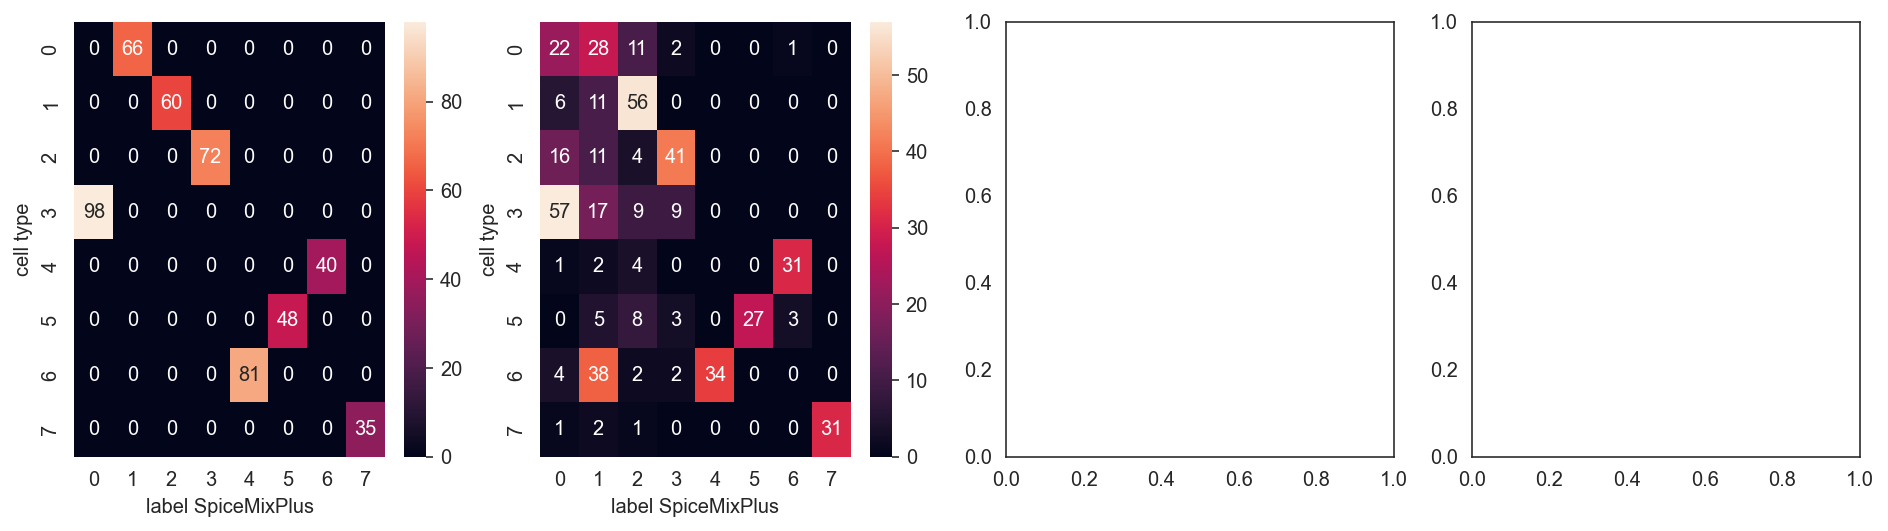

sil 0.20426919


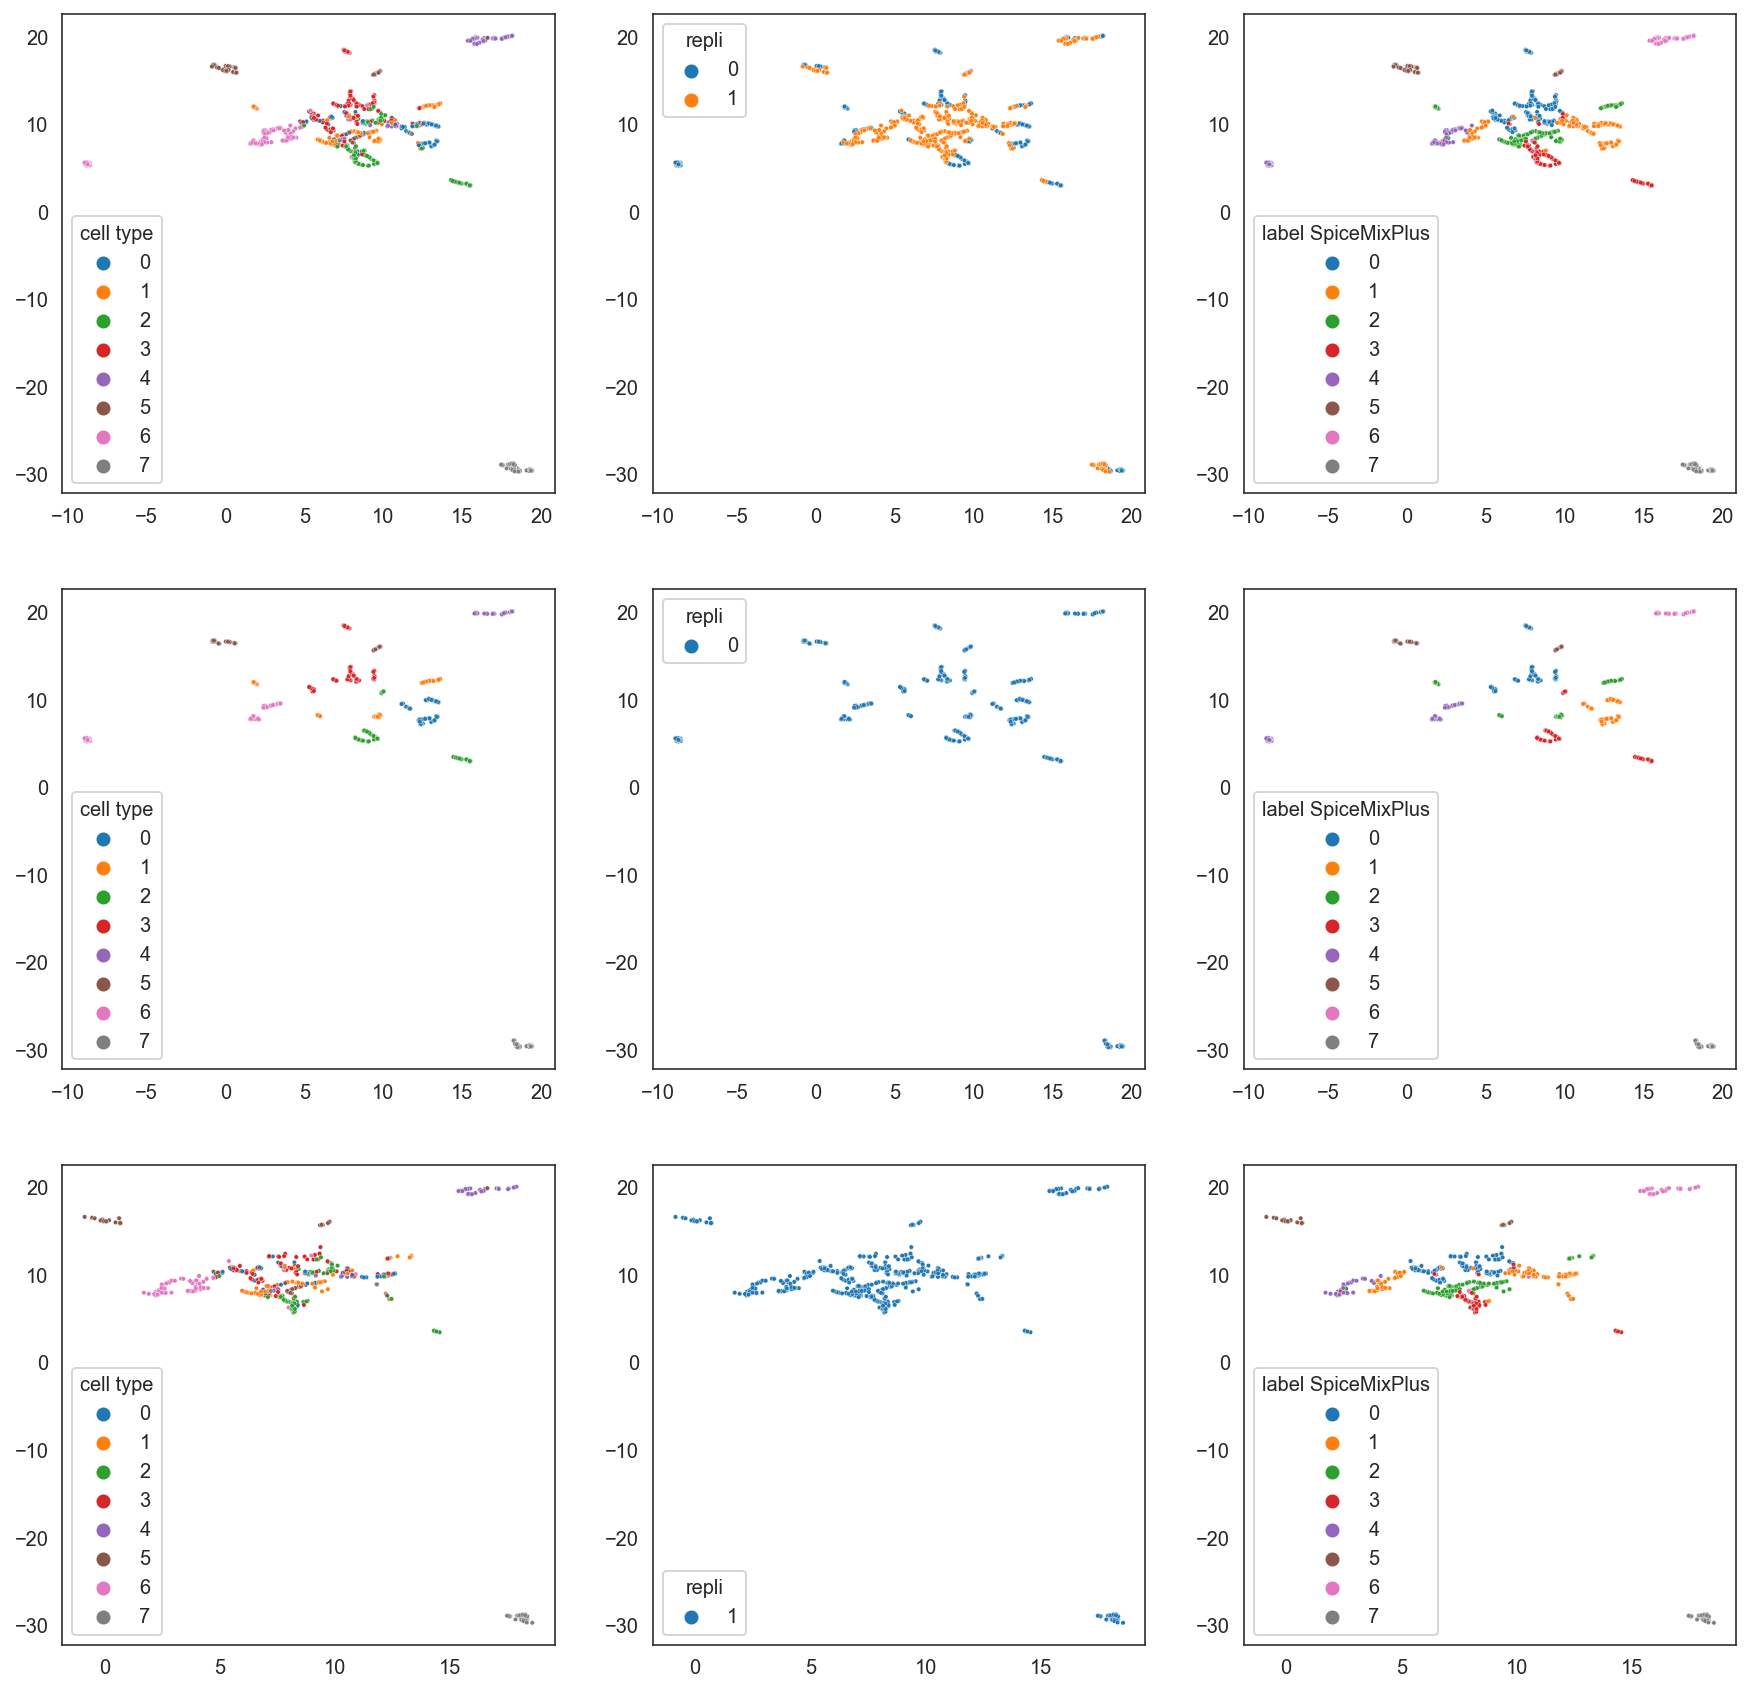

,acc,f1 micro,f1 macro,ari
0,1.000,1.000,1.000000,1.000000
1,0.646,0.646,0.665339,0.364853


  0%|          | 0/20 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Louvain clustering: res=3.16e-01:   0%|          | 0/100 [00:00<?, ?it/s]

binary search for resolution: lb=0.10	rb=1.00	mid=0.32	n_clust=7


Louvain clustering: res=5.62e-01:   0%|          | 0/100 [00:00<?, ?it/s]

binary search for resolution: lb=0.32	rb=1.00	mid=0.56	n_clust=8
ari = 0.75
ari 0 = 0.99
ari 1 = 0.56


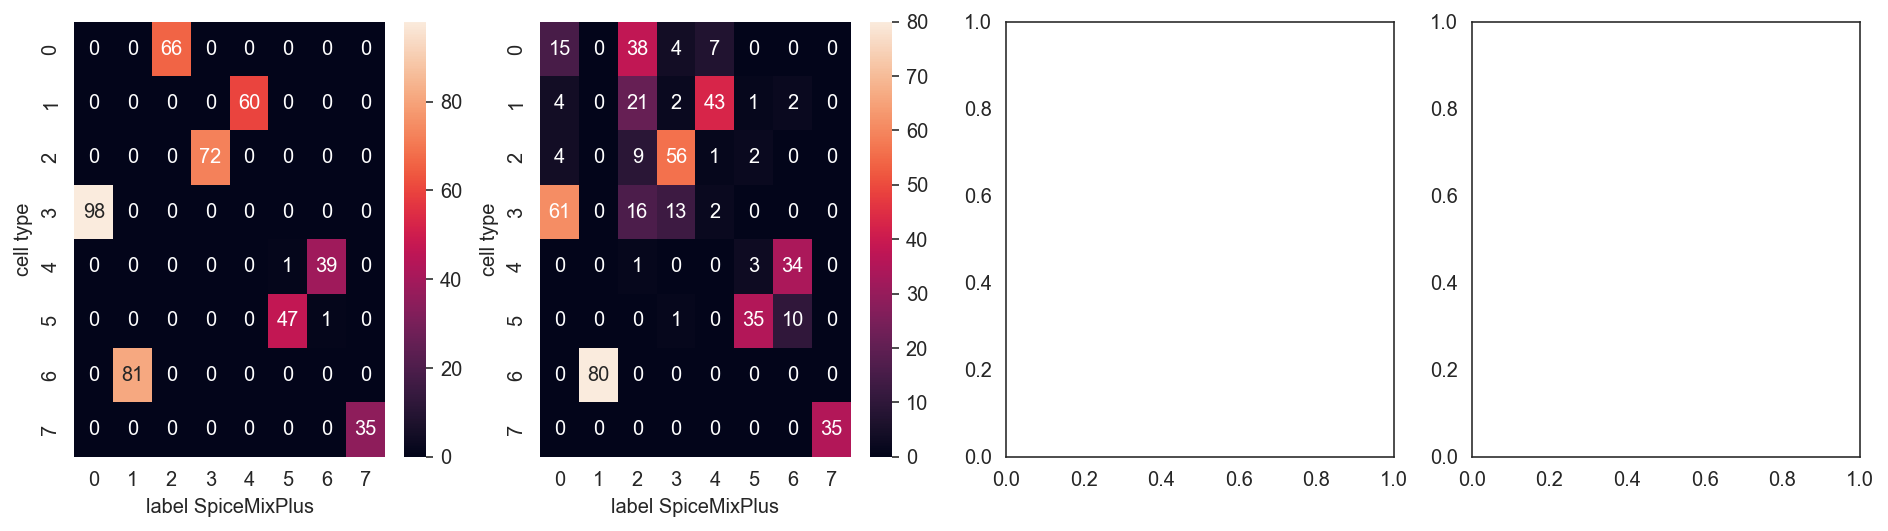

sil 0.50956243


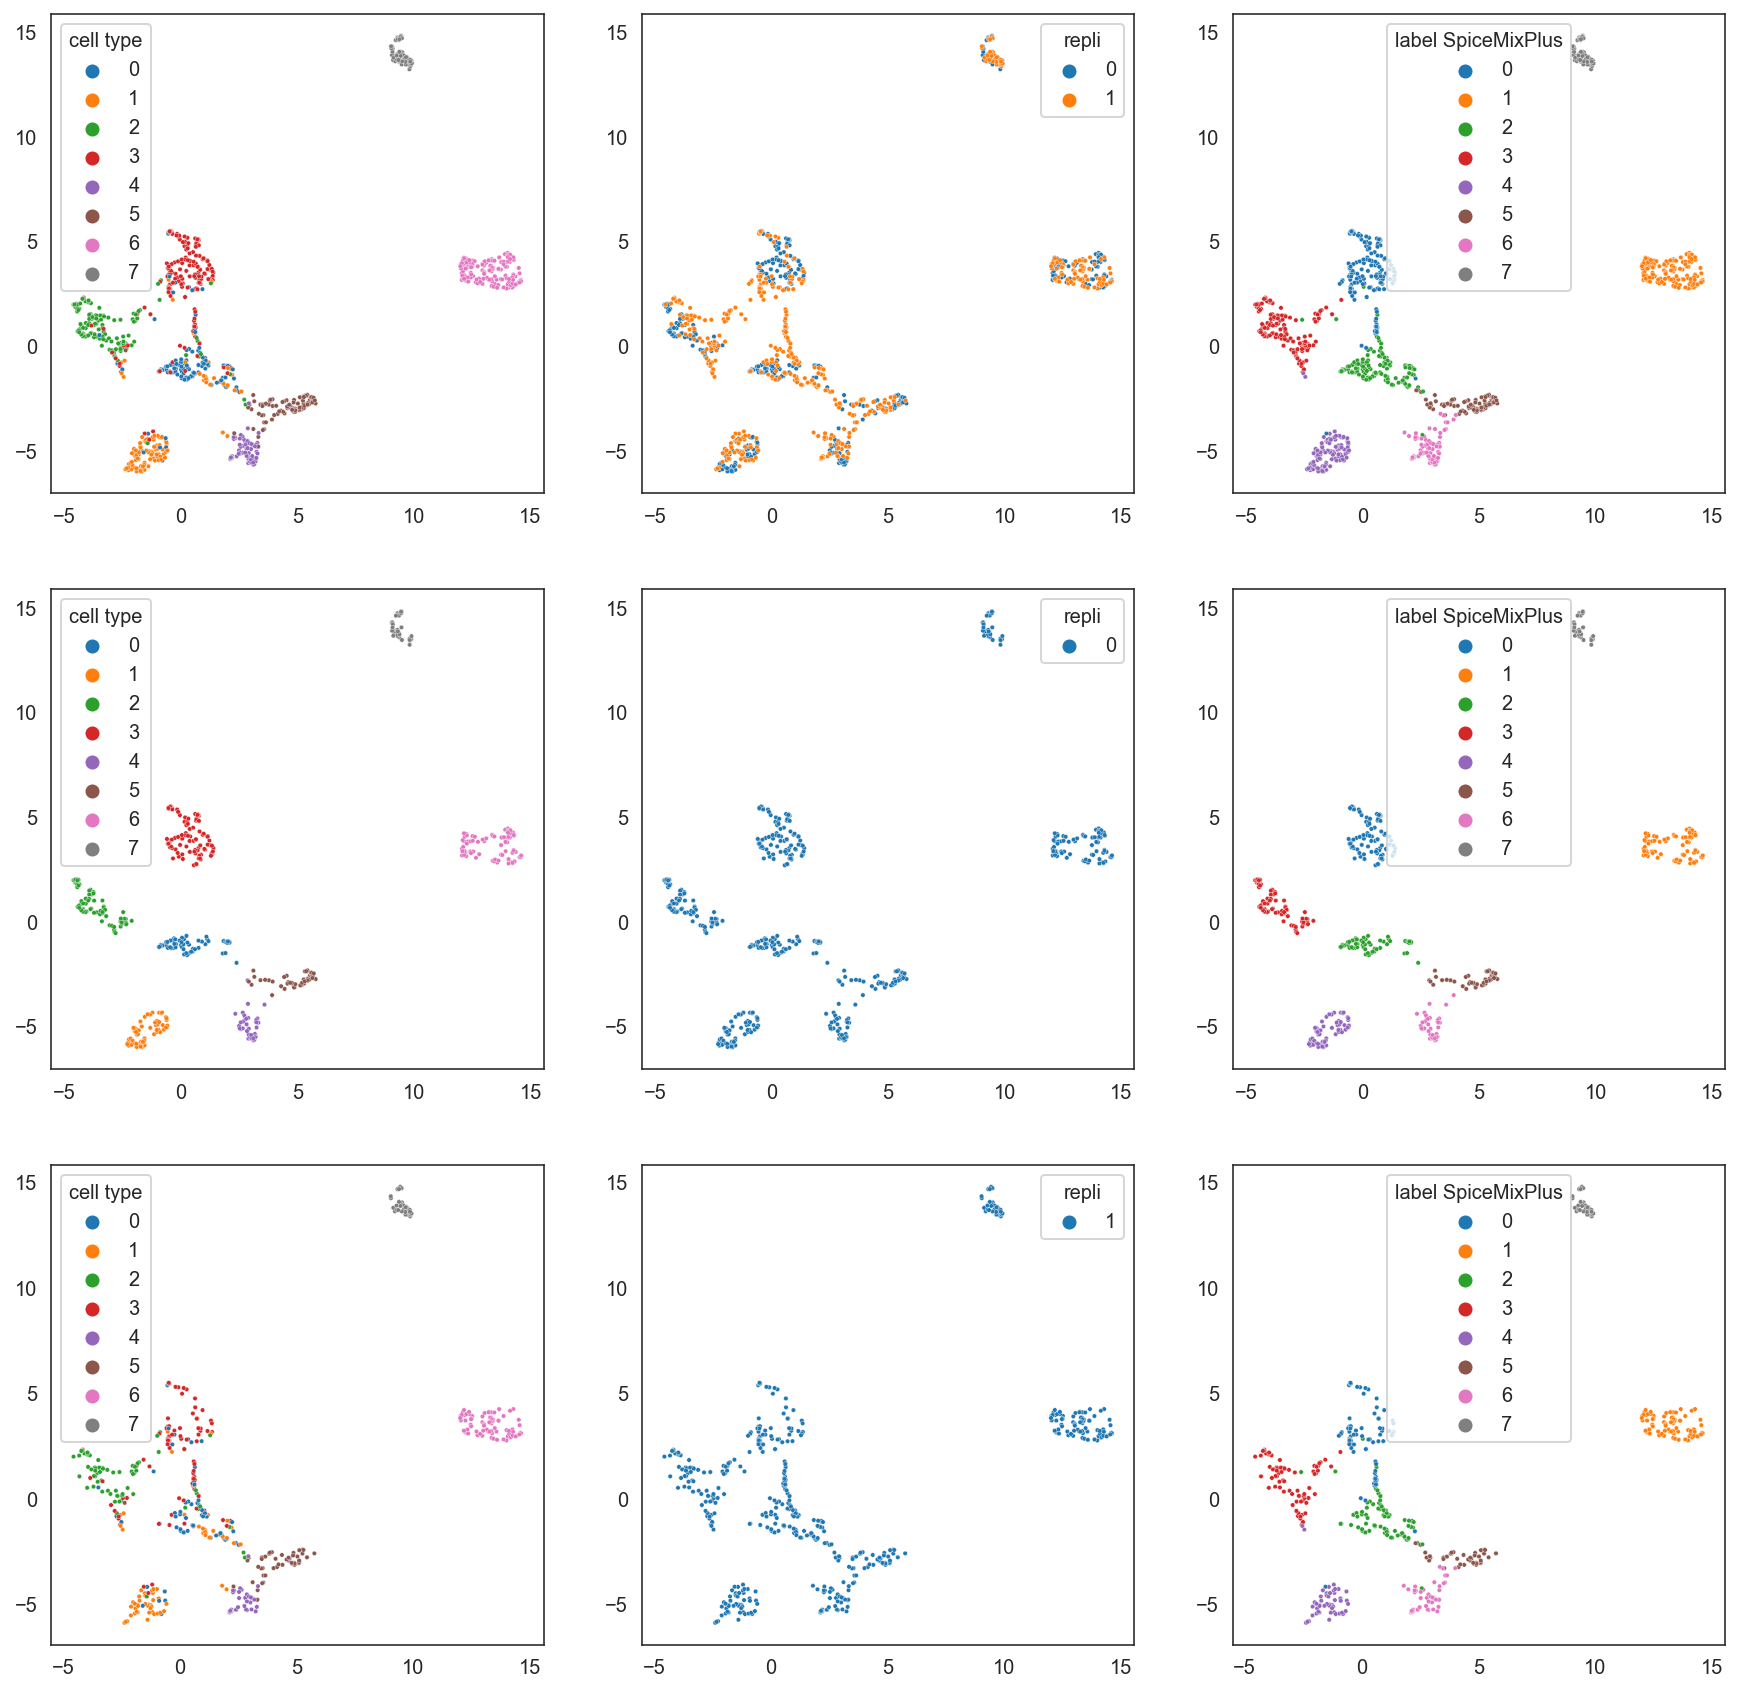

,acc,f1 micro,f1 macro,ari
0,0.908,0.908,0.845384,0.861264
1,0.616,0.616,0.546683,0.375294


Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Updating Σx-1:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating M:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating `cell type encoded` predictor:   0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating Z w/ nbrs w/ ph.:   0%|          | 0/500 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
%%time
reload_all()
from model import SpiceMixPlus
from util import clustering_louvain_nclust, evaluate_embedding, evaluate_prediction_wrapper
from sklearn.cluster import AgglomerativeClustering


# evaluate = lambda obj, f=evaluate_embedding: f(obj, embedding='X', do_plot=True, do_sil=True)
def evaluate(obj):
    evaluate_embedding(obj, embedding='X', do_plot=True, do_sil=True)
    evaluate_prediction_wrapper(obj, display_fn=display)

K = 10

obj = SpiceMixPlus(
    K=K, lambda_Sigma_x_inv=1e-5,
    repli_list=repli_list,
    context=context,
#     context_Y=dict(dtype=torch.float32, device='cpu'),
    context_Y=context,
)
obj.load_dataset(path2dataset)
obj.meta['cell type'] = obj.meta['cell type'].astype('category')

phenotype2predictor = {}
df = obj.meta
# cell type
label_raw = df['cell type']
label_a2i = dict(zip(np.unique(label_raw), itertools.count()))
label = list(map(label_a2i.get, label_raw))
df['cell type encoded'] = np.array(label, dtype=int)
predictor = nn.Linear(K, len(set(label)))
predictor = predictor.to(context['device'])
predictor.weight.data.normal_()
predictor.bias.data.normal_()
optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-2, weight_decay=1e-2)
# loss_fn = nn.CrossEntropyLoss()
def loss_fn(yhat, y, state):
    if state == 'train':
         return torch.nn.functional.cross_entropy(yhat, y, reduction='mean')
    elif state == 'eval':
         return torch.nn.functional.cross_entropy(yhat, y, reduction='sum') * 1e1
    else:
        raise NotImplementError
phenotype2predictor['cell type encoded'] = (predictor, optimizer, loss_fn)
del label_raw, label, predictor, optimizer, loss_fn
obj.register_phenotype(phenotype2predictor)
obj.phenotypes[1]['cell type encoded'] = None

obj.initialize(
#     method='kmeans',
    method='svd',
#     random_state=4,
)
evaluate(obj)
for iiter in trange(20):
    obj.estimate_parameters(iiter=iiter, use_spatial=[False]*obj.num_repli)
    obj.estimate_weights(iiter=iiter, use_spatial=[False]*obj.num_repli)
evaluate(obj)
obj.initialize_Sigma_x_inv()

# obj.phenotypes = [{}]
# obj.phenotype_predictors = None

# obj.register_phenotype(phenotype2predictor)

for iiter in range(1, 101):
    obj.estimate_parameters(iiter=iiter, use_spatial=[True]*obj.num_repli)
    obj.estimate_weights(iiter=iiter, use_spatial=[True]*obj.num_repli)
    if iiter % 50 == 0:
        evaluate(obj)

In [21]:
%debug

> /home/tianming/Researches/RNAseq-seqFISH/version1/scripts10/util.py(185)evaluate_prediction_wrapper()
    183         obj.meta['label SpiceMixPlus predictor'] = obj.phenotype_predictors[key_truth][0](X_all)\
    184                 .argmax(1).cpu().numpy()
--> 185         display_fn(evaluate_prediction(obj.meta, key_pred='label SpiceMixPlus predictor', key_truth=key_truth, **kwargs))
    186 
    187 

ipdb> evaluate_prediction(obj.meta, key_pred='label SpiceMixPlus predictor', key_truth=key_truth, **kwargs)
     acc  f1 micro  f1 macro       ari
0  0.747     0.747  0.781471  0.470119
1  0.747     0.747  0.781471  0.470119
ipdb> display_fn
ipdb> quit


In [40]:
reload_all()
from util import evaluate_prediction

X_train = obj.Xs[0].cpu().numpy()
X_all = np.concatenate([X.cpu().numpy() for X in obj.Xs], axis=0)
y_train = obj.meta.groupby('repli').get_group('0')['cell type'].values

# from sklearn.linear_model import LogisticRegression
# for C in 10.**np.arange(-5, 0):
#     print(C)
#     clf = LogisticRegression(C=C)
#     obj.meta['label baseline'] = clf.fit(X_train, y_train).predict(X_all)
#     display(evaluate_prediction(obj.meta, key_pred='label baseline'))

from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in np.arange(5, 31, 5):
    print(n_neighbors)
    clf = KNeighborsClassifier(n_neighbors)
    obj.meta['label baseline'] = clf.fit(X_train, y_train).predict(X_all)
    display(evaluate_prediction(obj.meta, key_pred='label baseline'))

5


,acc,f1 micro,f1 macro,ari
0,0.996,0.996,0.995786,0.990522
1,0.906,0.906,0.884225,0.833206


10


,acc,f1 micro,f1 macro,ari
0,0.994,0.994,0.992684,0.987902
1,0.902,0.902,0.878736,0.825855


15


,acc,f1 micro,f1 macro,ari
0,0.994,0.994,0.993165,0.987103
1,0.894,0.894,0.867087,0.811172


20


,acc,f1 micro,f1 macro,ari
0,0.990,0.990,0.986866,0.981443
1,0.878,0.878,0.838881,0.787541


25


,acc,f1 micro,f1 macro,ari
0,0.986,0.986,0.981336,0.974285
1,0.874,0.874,0.831745,0.780652


30


,acc,f1 micro,f1 macro,ari
0,0.980,0.980,0.973159,0.963434
1,0.862,0.862,0.806787,0.765519


In [1]:
reload_all()
from util import evaluate_prediction
X_all = torch.cat([X for X in obj.Xs], axis=0)
obj.meta['label SpiceMixPlus predictor'] = obj.phenotype_predictors['cell type encoded'][0](X_all).argmax(1).cpu().numpy()
display(evaluate_prediction(obj.meta, key_pred='label SpiceMixPlus predictor'))

NameError: name 'reload_all' is not defined

In [79]:
reload_all()
from estimate_weights import estimate_weight_wonbr, estimate_weight_wnbr
N, G, K = 100, 50, 5
M = torch.rand(G, K, **context)
X = torch.rand(N, K, **context)
Y = X @ M.T + torch.randn(N, G, **context)*1e-2
Y.clip_(min=0)

X1 = X.clone()
estimate_weight_wonbr(
    Y, M, X1, 1, 
    'exponential shared fixed', (torch.full([K], 1e-2, **context),), context=context)
X2 = X.clone()
estimate_weight_wnbr(
    Y, M, X2, 1, 
    None, [[i] for i in range(N)],
    'exponential shared fixed', (torch.full([K], 1e-2, **context),), context=context)
print(torch.linalg.norm(X1-X2))
print(torch.linalg.norm(Y - X @ M.T))
print(torch.linalg.norm(Y - X1 @ M.T))
print(torch.linalg.norm(Y - X2 @ M.T))

  0%|          | 0/10000 [00:00<?, ?it/s]

Updating weight w/ neighbors:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.0083, device='cuda:0')
tensor(0.7111, device='cuda:0')
tensor(0.6753, device='cuda:0')
tensor(0.6754, device='cuda:0')
